In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BID Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.65 * len(df1))
test_size = int(0.25 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 99ms/step - loss: 0.0669 - val_loss: 0.0308
Epoch 2/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0096 - val_loss: 0.0039
Epoch 3/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0052 - val_loss: 0.0219
Epoch 4/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0043 - val_loss: 0.0104
Epoch 5/100
12/12 [==============================] - 1s 47ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 6/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 7/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/100
12/12 [==============================] - 1s 58ms/step - loss: 9.2947e-04 - val_loss: 0.

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 8ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 906.2721210758173
Testing RMSE: 915.700977296182


In [15]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.015734771980476275
Testing MAPE: 0.01786088210673257


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=74
i=0
while(i<30):
    
    if(len(temp_input)>74):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.90461725]
75
1 day input [0.68277043 0.68585033 0.69201013 0.68893023 0.68585033 0.67661063
 0.67969053 0.69201013 0.69201013 0.68585033 0.72280911 0.78132719
 0.72280911 0.67969053 0.7597679  0.7474483  0.74590835 0.77362744
 0.7536081  0.7628478  0.76130785 0.76746765 0.77824729 0.86756435
 0.8752641  0.87988395 0.90606309 0.86294451 0.86140456 0.87988395
 0.80904628 0.81982592 0.82598572 0.87680405 0.83984527 0.86140456
 0.84600506 0.81366613 0.85832466 0.82752567 0.84600506 0.87680405
 0.90144324 0.94456182 0.91530278 0.87680405 0.89374349 0.86448446
 0.85370481 0.84908496 0.89682339 0.91992263 0.90452314 0.90144324
 0.93532213 0.96920101 0.95842137 0.94302187 0.91530278 0.878344
 0.93224223 0.91530278 0.91684273 0.8875837  0.8875837  0.91068294
 0.90452314 0.89374349 0.90760304 0.90760304 0.91376284 0.91376284
 0.91376284 0.90461725]
1 day output [[0.89745426]]
2 day input [0.68585033 0.69201013 0.68893023 0.68585033 0.67661063 0.67969053
 0.69201013 0.69201013 0.68585033 0.722

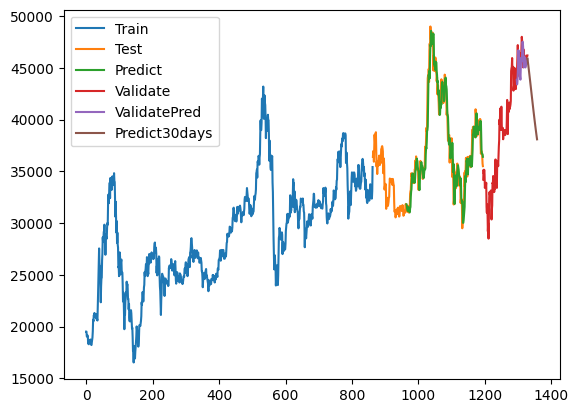

In [17]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [18]:
print(scaler.inverse_transform(lst_output))

[[45903.05564224]
 [45670.48344402]
 [45415.57425133]
 [45152.33368095]
 [44883.80979789]
 [44610.97991824]
 [44334.50977809]
 [44054.96641431]
 [43772.97105156]
 [43489.11782062]
 [43203.86731797]
 [42917.56789391]
 [42630.84657894]
 [42344.5452196 ]
 [42058.74896817]
 [41773.6416762 ]
 [41490.07873716]
 [41208.27883763]
 [40928.64064516]
 [40651.70410268]
 [40377.69950845]
 [40107.02940058]
 [39839.9608476 ]
 [39576.70285971]
 [39317.40638869]
 [39062.71007673]
 [38812.77842257]
 [38567.87268894]
 [38328.40315505]
 [38094.36595036]]
